## Gesture Recognition System

In [14]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from numpy.fft import rfft, rfftfreq
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import json
from scipy.stats import kurtosis, skew, iqr
from sklearn.feature_selection import RFE

def load_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    # Create a list of DataFrames, one for each gesture
    dfs = []        
    for item in data:
        df = pd.DataFrame({
            'timestamps': item['timestamps'],
            'xTimeSeries': item['xTimeSeries'],
            'yTimeSeries': item['yTimeSeries'],
            'zTimeSeries': item['zTimeSeries'],
            'label': item['label']
        })
        dfs.append(df)
    return dfs

### Signal preprocessing

In [15]:
def preprocess_signal_bandpass(data, lowcut=5.0, highcut=25.0, fs=50, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=True)
    y = filtfilt(b, a, data)
    return y


### Feature extraction

In [16]:
import numpy as np
from scipy.stats import kurtosis, skew

def extract_features(segment):
    features = []
    m_axis_data = []  # For M-axis calculation

    for axis in ['xTimeSeries', 'yTimeSeries', 'zTimeSeries']:
        axis_data = np.array(segment[axis])
        m_axis_data.append(axis_data)
        
        # Time domain features
        features += [
            np.mean(axis_data),  # Mean
            np.std(axis_data),   # Standard Deviation
            np.ptp(axis_data),   # Peak to peak (range)
            np.min(axis_data),   # Minimum
            np.max(axis_data),   # Maximum
            np.sum(np.abs(axis_data)) / len(axis_data),  # SMA (for this axis, later average across all axes)

        ]

        # Average absolute increment
        avg_abs_increment = np.mean(np.abs(np.diff(axis_data)))
        features.append(avg_abs_increment)

        # Mean-crossings (a variant of zero-crossings focusing on mean level)
        mean = np.mean(axis_data)
        mean_crossings = np.sum(np.diff(axis_data - mean > 0).astype(int))
        features.append(mean_crossings)

        # Frequency domain features
        features += extract_frequency_features(axis_data)

    # Pairwise correlations
    for i in range(3):
        for j in range(i+1, 3):
            correlation = np.corrcoef(m_axis_data[i], m_axis_data[j])[0, 1]
            features.append(correlation)

    return features

import numpy as np

def extract_frequency_features(data):
    fft_vals = np.fft.rfft(data)  # Real FFT
    spectral_energy = np.sum(np.abs(fft_vals)**2) / len(fft_vals)
    freqs = np.fft.rfftfreq(len(data))
    centroid = np.sum(freqs * np.abs(fft_vals)) / np.sum(np.abs(fft_vals))
    return [spectral_energy, centroid]



### Training

In [17]:
def train_classifier(features, labels):
    model = make_pipeline(StandardScaler(), SVC(max_iter= 10000))
    model.fit(features, labels)

    return model

def predict_with_confidence(model, features, threshold = 1):
    decision_values = model.decision_function([features])
    prediction = model.predict([features])
    confidence = np.abs(decision_values[0])  # Use absolute value for confidence
    if confidence < threshold:
        return "Other", confidence  # Return empty label if below threshold
    else:
        return prediction[0], confidence  # Return prediction and confidence otherwise

In [18]:
import matplotlib.pyplot as plt

def plot_preprocessed_data(dataframes):
    for i, df in enumerate(dataframes):
        # Original data
        if i < 3:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 2, 1)
            plt.plot(df['timestamps'], df['xTimeSeries'], label='Original X', color='red')
            plt.plot(df['timestamps'], df['yTimeSeries'], label='Original Y', color='green')
            plt.plot(df['timestamps'], df['zTimeSeries'], label='Original Z', color='blue')
            plt.title('Original Accelerometer Data')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')
            plt.legend()

        # Preprocessed data
        df['xTimeSeries'] = preprocess_signal_bandpass(df['xTimeSeries'])
        df['yTimeSeries'] = preprocess_signal_bandpass(df['yTimeSeries'])
        df['zTimeSeries'] = preprocess_signal_bandpass(df['zTimeSeries'])
        if i < 3:
            plt.subplot(1, 2, 2)
            plt.plot(df['timestamps'], df['xTimeSeries'], label='Preprocessed X', color='red')
            plt.plot(df['timestamps'], df['yTimeSeries'], label='Preprocessed Y', color='green')
            plt.plot(df['timestamps'], df['zTimeSeries'], label='Preprocessed Z', color='blue')
            plt.title('Preprocessed Accelerometer Data')
            plt.xlabel('Time')
            plt.ylabel('Acceleration')
            plt.legend()
            plt.tight_layout()
            plt.show()


### In-Practice Usage

In [19]:
from sklearn.model_selection import train_test_split
 
# Load gesture data
"""
dataframes = load_data('labeled_train_data/labeled_data_circle.json')  + load_data('labeled_train_data/labeled_data_clap.json')
random_dataframes = load_data('labeled_train_data/labeled_data_random.json')

# Plot preprocessed data for visual inspection (if preprocess is defined and required here)
# plot_preprocessed_data(dataframes)

# Prepare features and labels for gesture data
"""
features_file = json.loads(open('features.json', 'r').read())
features = [f["features"] for f in features_file if f["label"] != "Other"]
labels = [l["label"] for l in features_file if l["label"] != "Other"]
"""
features = []
labels = []
for df in dataframes:
    # Preprocess the data here if necessary, e.g., df['xTimeSeries'] = preprocess_signal(df['xTimeSeries'])
    f = extract_features(df)
    features.append(f)
    labels.append(df['label'].iloc[0])  # Assuming all entries in a df have the same label
"""
# Split the gesture data into training and testing sets
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42)

# Prepare features and labels for random data, and use them only in the testing phase
random_features = [f["features"] for f in features_file if f["label"] == "Other"]
random_labels = [l["label"] for l in features_file if l["label"] == "Other"]
"""
random_features = []    
random_labels = []
for df in random_dataframes:
    # Preprocess the random data here if necessary
    
    random_features.append(extract_features(df))
    random_labels.append('No Gesture')  # Label all random movements as 'No Gesture'
"""
# Combine the test set with the random data
features_test.extend(random_features)
labels_test.extend(random_labels)

# Train the classifier on the training set
model = train_classifier(features_train, labels_train)

# Evaluate the classifier on the testing set (now includes random data)
predictions_test = []
confidences_test = []
for feature in features_test:
    prediction, confidence = predict_with_confidence(model, feature)
    predictions_test.append(prediction)
    confidences_test.append(confidence)

for i, tup in enumerate(zip(predictions_test, labels_test)):
    print(f"Predicted: {tup[0]}, Actual: {tup[1]}, with confidence: {confidences_test[i]:.2f}")

# Calculate accuracy on the testing data including random data
accuracy_test = sum(1 for p, l in zip(predictions_test, labels_test) if p == l) / len(labels_test)
print(f"Accuracy on test data including random movements: {accuracy_test:.2f}")


Predicted: Circle, Actual: Circle, with confidence: 1.16
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.07
Predicted: Circle, Actual: Circle, with confidence: 1.05
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Circle, Actual: Circle, with confidence: 1.21
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.18
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.00
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.10
Predicted: Circle, Actual: Circle, with confidence: 1.14
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.33
Predicted: Other, Actual: Double Clap, with confidence: 0.98
Predicted: Double Clap, Actual: Double Clap, with confidence: 1.18
Predicted: Other, Actual: Double Clap, with confidence: 0.89
Predicted: Circle, Actual: Circle, with confidence: 1.26
Predicted: Circle, A

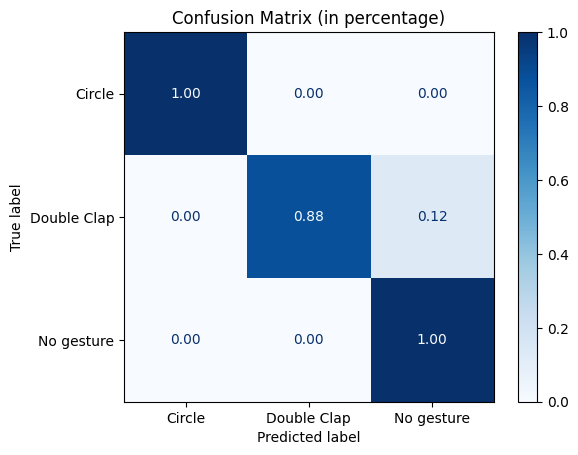

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming predictions_test and labels_test contain your predicted and true labels respectively
cm = confusion_matrix(labels_test, predictions_test)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Identify unique label names and replace "Other" with "No gesture"
unique_labels = np.unique(labels_test)
unique_labels = ["No gesture" if label == "Other" else label for label in unique_labels]

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=unique_labels)
disp.plot(cmap=plt.cm.Blues, values_format='.2f')
plt.title("Confusion Matrix (in percentage)")
plt.show()


### Conversion to ONNX

In [21]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

feature_count = len(features_train[0])  # Replace this with the actual number of features if known
initial_type = [('float_input', FloatTensorType([None, feature_count]))]

onnx_model = convert_sklearn(model, initial_types=initial_type)

# Save the ONNX model to a file
with open("gesture_classifier.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

ModuleNotFoundError: No module named 'skl2onnx'

In [ ]:
import onnxruntime as rt
import numpy as np

def onnx_predict_with_confidence(onnx_model_path, features, threshold=1):
    # Load the ONNX model
    sess = rt.InferenceSession(onnx_model_path)
    input_name = sess.get_inputs()[0].name
    output_label = sess.get_outputs()[0].name  # The predicted label output
    output_probability = sess.get_outputs()[1].name  # The probabilities output

    # Run the model (ensure features is a numpy array and correctly shaped)
    probabilities = sess.run([output_probability], {input_name: np.array([features], dtype=np.float32)})[0]
    predictions = sess.run([output_label], {input_name: np.array([features], dtype=np.float32)})[0]
    
    # Calculate confidence (the highest class probability)
    max_prob = np.max(probabilities)
    prediction = predictions[0]

    if max_prob < threshold:
        return "Other", max_prob
    else:
        return prediction, max_prob

# Example usage
predictions_test = []
confidences_test = []
for feature in features_test:
    prediction, confidence = onnx_predict_with_confidence("gesture_classifier.onnx",feature)
    predictions_test.append(prediction)
    confidences_test.append(confidence)
    
conf_total = 0
for i, tup in enumerate(zip(predictions_test, labels_test)):
    print(f"Predicted: {tup[0]}, Actual: {tup[1]}, with confidence: {confidences_test[i]:.2f}")
    conf_total += confidences_test[i]

# Calculate accuracy on the testing data including random data
accuracy_test = sum(1 for p, l in zip(predictions_test, labels_test) if p == l) / len(labels_test)
avg_conf = conf_total / len(labels_test)
print(f"Accuracy on test data including random movements: {accuracy_test:.2f} and average confidence: {avg_conf:.2f}")



Predicted: Circle, Actual: Circle, with confidence: 1.16
Predicted: Clap, Actual: Clap, with confidence: 1.07
Predicted: Circle, Actual: Circle, with confidence: 1.05
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Circle, Actual: Circle, with confidence: 1.21
Predicted: Clap, Actual: Clap, with confidence: 1.18
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Clap, Actual: Clap, with confidence: 1.00
Predicted: Clap, Actual: Clap, with confidence: 1.10
Predicted: Circle, Actual: Circle, with confidence: 1.14
Predicted: Circle, Actual: Circle, with confidence: 1.12
Predicted: Clap, Actual: Clap, with confidence: 1.33
Predicted: Other, Actual: Clap, with confidence: 0.98
Predicted: Clap, Actual: Clap, with confidence: 1.18
Predicted: Other, Actual: Clap, with confidence: 0.89
Predicted: Circle, Actual: Circle, with confidence: 1.26
Predicted: Circle, Actual: Circle, with confidence: 1.01
Predicted: Clap, Actual: Clap, with confidence: 1.35
Predicte